In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 读取（下载）MNIST数据集

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 归一化到[-1, 1]，更适合tanh激活函数
])

"""
num_workers=4 : 使用 4 个子进程来并行加载数据，这可以加快数据加载速度
pin_memory=True : 将加载的数据张量固定在内存, 数据加载到 GPU 的速度会更快, 通常在使用 GPU 训练时，将此参数设置为 True
"""
train_dataset = datasets.MNIST(root='../datasets/mnist', train=True, download=True, transform=transform)  # download=True:如果没有, 下载数据集
test_dataset = datasets.MNIST(root='../datasets/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

In [3]:
# 增大batch_size以提高稳定性
batch_size = 128

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

### 构建模型
**Generator 和 Discriminator**

[反卷积(Transposed conv deconv)实现原理（通俗易懂）](https://blog.csdn.net/weixin_39326879/article/details/120797857) : 在GAN中，生成器使用反卷积层将低维随机噪声转换为高分辨率图像

#### 反卷积层（Deconvolution Layer）

反卷积层，也称为**转置卷积层（Transposed Convolution Layer）**，是一种用于上采样的操作。它的作用是将低分辨率的特征图（feature map）转换为高分辨率的特征图。反卷积层在生成对抗网络（GAN）、图像分割、超分辨率等任务中非常常见。


| 特性                | 卷积层（Convolution）                          | 反卷积层（Transposed Convolution）            |
|---------------------|-----------------------------------------------|-----------------------------------------------|
| **目的**            | 下采样，提取特征                              | 上采样，生成高分辨率特征图                    |
| **输入与输出关系**  | 输入尺寸 > 输出尺寸                           | 输入尺寸 < 输出尺寸                           |
| **计算方式**        | 通过滑动窗口和卷积核计算输出                  | 通过填充和卷积核的转置计算输出                |
| **应用场景**        | 特征提取、分类、检测等                        | 图像生成、分割、超分辨率等                    |

#### Generator 
生成器的目标是从随机噪声（latent vector）和条件（condition）生成逼真的图像

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, class_num=10):
        '''
        初始化生成网络
        :param input_dim:输入随机噪声的维度，（随机噪声是为了增加输出多样性）
        :param output_dim:生成图像的通道数（灰度图为1，RGB图为3）
        :param class_num:图像种类
        '''
        super(Generator, self).__init__()
        """
         为什么需要拼接随机噪声和条件向量？
         拼接随机噪声和条件向量的目的是将两种信息结合起来，作为生成器的输入：
         随机噪声：提供生成数据的随机性。
         条件向量：提供生成数据的条件信息。
         通过拼接，生成器可以根据条件向量生成符合特定条件的数据, 同时确保每次生成的数据会有所不同
         """
        self.input_dim = input_dim
        self.class_num = class_num
        self.output_dim = output_dim
        
        # 嵌入层处理条件向量(类别标签), 提高条件信息的表达能力
        self.label_emb = nn.Embedding(class_num, class_num)
        
        # 全连接层，将输入向量映射到高维空间，然后通过反卷积层生成图像
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 反卷积层（转置卷积层），用于将高维特征图逐步上采样为最终图像
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 2, 1),  # 7x7 -> 14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.output_dim, 3, 1, 1),  # 保持尺寸不变，但细化特征
            nn.Tanh()  # 激活函数，将输出值限制在 [-1, 1] 范围内，适合生成图像
        )
 
    def forward(self, noise, labels):
        # 标签处理
        label_embedding = self.label_emb(labels)
        
        # 拼接噪声和条件向量
        x = torch.cat([noise, label_embedding], dim=1)
        
        # 通过全连接层
        x = self.fc(x)
        
        # 重塑为特征图
        x = x.view(-1, 128, 7, 7)
        
        # 通过反卷积层生成图像
        x = self.deconv(x)
        
        return x

#### Discriminator 
判别器的目标是区分输入图像是真实的还是生成的

In [5]:
import torch.nn.utils.spectral_norm as spectral_norm

class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, class_num=10):
        '''
        初始化判别网络
        :param input_dim:输入通道数
        :param output_dim:输出通道数
        '''
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num

        # 标签嵌入
        self.label_emb = nn.Embedding(class_num, 28*28)

        # 卷积层使用频谱归一化提高稳定性
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim + 1, 64, 4, 2, 1),  # +1 是为了连接条件信息
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # 添加Dropout防止过拟合
            
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),  # 频谱归一化
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, 1, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(256 * 7 * 7, 1024)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(1024, self.output_dim))
        )
 
    def forward(self, img, labels):
        # 处理标签
        batch_size, _, height, width = img.shape
        label_embedding = self.label_emb(labels).view(batch_size, 1, height, width)
        
        # 连接图像和标签信息
        x = torch.cat([img, label_embedding], dim=1)
        
        # 卷积层
        x = self.conv(x)
        
        # 全连接层
        x = x.view(batch_size, -1)
        x = self.fc(x)
        
        return x

### 模型训练

In [6]:
# 初始化权重函数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 定义生成器和判别器
generator = Generator(input_dim=100, output_dim=1, class_num=10).to(device)
discriminator = Discriminator(input_dim=1, output_dim=1, class_num=10).to(device)

# 应用权重初始化
generator.apply(weights_init)
discriminator.apply(weights_init)

# 使用Adam优化器，beta参数适合GAN训练
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


# 使用Wasserstein GAN with Gradient Penalty (WGAN-GP)损失函数
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """计算梯度惩罚项"""
    # 随机权重项
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    
    # 在真实样本和生成样本之间进行插值
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # 计算插值样本的判别器输出
    d_interpolates = D(interpolates, labels)
    
    # 获取梯度
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # 梯度惩罚
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [7]:
def train(dataloader, generator, discriminator, optimizer_G, optimizer_D, epoch):
    generator.train()
    discriminator.train()
    running_loss_G = 0.0
    running_loss_D = 0.0
    
    lambda_gp = 10  # 梯度惩罚权重
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for index, (images, labels) in enumerate(progress_bar):
        # 将数据移动到设备
        batch_size = images.size(0)
        images = images.to(device)
        labels = labels.to(device)
        
        # ---------------------
        #  训练判别器
        # ---------------------
        optimizer_D.zero_grad()
        
        # 生成随机噪声
        z = torch.randn(batch_size, generator.input_dim).to(device)
        
        # 生成假图像
        fake_images = generator(z, labels)
        
        # 计算真实和假图像的判别器输出
        real_validity = discriminator(images, labels)
        fake_validity = discriminator(fake_images.detach(), labels)
        
        # 梯度惩罚项
        gradient_penalty = compute_gradient_penalty(
            discriminator, images.data, fake_images.data, labels
        )
        
        # 判别器损失 (WGAN-GP)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        
        # 更新判别器
        d_loss.backward()
        optimizer_D.step()
        
        running_loss_D += d_loss.item()
        
        # ---------------------
        #  训练生成器
        # ---------------------
        # 每n_critic次更新一次生成器
        n_critic = 5
        if index % n_critic == 0:
            optimizer_G.zero_grad()
            
            # 生成假图像
            fake_images = generator(z, labels)
            
            # 判别器对假图像的评估
            fake_validity = discriminator(fake_images, labels)
            
            # 生成器损失
            g_loss = -torch.mean(fake_validity)
            
            # 更新生成器
            g_loss.backward()
            optimizer_G.step()
            
            running_loss_G += g_loss.item()
            
            # 更新进度条
            progress_bar.set_postfix(
                epoch=epoch+1,
                G_loss=g_loss.item(),
                D_loss=d_loss.item()
            )
        
    avg_loss_G = running_loss_G / (len(dataloader) // n_critic)
    avg_loss_D = running_loss_D / len(dataloader)
    
    return avg_loss_G, avg_loss_D

In [8]:
def evaluate(dataloader, generator, discriminator, epoch):
    generator.eval()
    discriminator.eval()
    running_loss_G = 0.0
    running_loss_D = 0.0
    
    lambda_gp = 10  # 梯度惩罚权重
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=True)
        for images, labels in progress_bar:
            # 将数据移动到设备
            batch_size = images.size(0)
            images = images.to(device)
            labels = labels.to(device)
            
            # 生成随机噪声
            z = torch.randn(batch_size, generator.input_dim).to(device)
            
            # 生成假图像
            fake_images = generator(z, labels)
            
            # 计算真实和假图像的判别器输出
            real_validity = discriminator(images, labels)
            fake_validity = discriminator(fake_images, labels)
            
            # 判别器损失 (WGAN-GP)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
            
            # 生成器损失
            g_loss = -torch.mean(fake_validity)
            
            # 统计损失
            running_loss_G += g_loss.item()
            running_loss_D += d_loss.item()
            
            # 更新进度条
            progress_bar.set_postfix(
                epoch=epoch+1,
                G_loss=g_loss.item(),
                D_loss=d_loss.item()
            )
    
    avg_loss_G = running_loss_G / len(dataloader)
    avg_loss_D = running_loss_D / len(dataloader)
    
    return avg_loss_G, avg_loss_D

In [9]:
# 训练过程中生成图片方便查看训练效果
def generate_images(generator, epoch, fixed_noise=None, fixed_labels=None):
    generator.eval()
    with torch.no_grad():
        num_images = 100
        num_classes = 10
        
        # 使用固定噪声和标签以便比较不同epoch的进展
        if fixed_noise is None:
            fixed_noise = torch.randn(num_images, generator.input_dim).to(device)
        if fixed_labels is None:
            # 每个数字类别生成10张图片
            fixed_labels = torch.tensor([i for i in range(num_classes) for _ in range(num_images // num_classes)]).to(device)
        
        # 生成图片
        fake_images = generator(fixed_noise, fixed_labels)
        fake_images = fake_images.cpu().detach()
        
        # 可视化并保存图片
        fig, axes = plt.subplots(10, 10, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
        for i, ax in enumerate(axes.flat):
            # 转换图像范围从[-1, 1]到[0, 1]
            img = (fake_images[i].squeeze() + 1) / 2
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # 在每行的第一列显示类别标签
            if i % 10 == 0:
                ax.set_title(f'{fixed_labels[i].item()}', fontsize=8)
        
        plt.savefig(f'./data/epoch_{epoch}.png', bbox_inches='tight')
        plt.close()
        
        return fixed_noise, fixed_labels

In [10]:
# 开始训练
num_epochs = 25
train_loss_G = []
train_loss_D = []
test_loss_G = []
test_loss_D = []

# 创建固定噪声和标签用于图像生成
fixed_noise = torch.randn(100, generator.input_dim).to(device)
fixed_labels = torch.tensor([i for i in range(10) for _ in range(10)]).to(device)

# 学习率调度器
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)

# 训练循环
for epoch in range(num_epochs):
    # 训练
    epoch_train_loss_G, epoch_train_loss_D = train(train_loader, generator, discriminator, optimizer_G, optimizer_D, epoch)
    
    # 在测试集上评估
    epoch_test_loss_G, epoch_test_loss_D = evaluate(test_loader, generator, discriminator, epoch)
    
    # 学习率调度
    scheduler_G.step(epoch_test_loss_G)
    scheduler_D.step(epoch_test_loss_D)
    
    # 记录损失
    train_loss_G.append(epoch_train_loss_G)
    train_loss_D.append(epoch_train_loss_D)
    test_loss_G.append(epoch_test_loss_G)
    test_loss_D.append(epoch_test_loss_D)
    
    # 打印训练和测试结果
    template = ('Epoch:{:2d}, Train_loss_G:{:.3f}, Train_loss_D:{:.3f}, Test_loss_G:{:.3f}, Test_loss_D:{:.3f}')
    print(template.format(epoch+1, epoch_train_loss_G, epoch_train_loss_D, epoch_test_loss_G, epoch_test_loss_D))
    
    # 每 5 个 epoch 生成并保存图片
    if (epoch + 1) % 5 == 0 or epoch == 0:
        generate_images(generator, epoch + 1, fixed_noise, fixed_labels)


print("训练完成!")

Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.20it/s, D_loss=-4.11, G_loss=-24.1, epoch=1]


Epoch: 1, Train_loss_G:-18.333, Train_loss_D:-8.840, Test_loss_G:-24.131, Test_loss_D:-3.791


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 24.53it/s, D_loss=-2.23, G_loss=-27.7, epoch=2]


Epoch: 2, Train_loss_G:-27.745, Train_loss_D:-2.964, Test_loss_G:-27.502, Test_loss_D:-2.433


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.51it/s, D_loss=-2.28, G_loss=-24.1, epoch=3]


Epoch: 3, Train_loss_G:-28.125, Train_loss_D:-2.190, Test_loss_G:-23.781, Test_loss_D:-2.352


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.11it/s, D_loss=-2.09, G_loss=-25.8, epoch=4]


Epoch: 4, Train_loss_G:-27.218, Train_loss_D:-2.240, Test_loss_G:-25.919, Test_loss_D:-2.526


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.35it/s, D_loss=-1.46, G_loss=-28.6, epoch=5]


Epoch: 5, Train_loss_G:-27.624, Train_loss_D:-1.984, Test_loss_G:-28.676, Test_loss_D:-1.854


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.16it/s, D_loss=-1.75, G_loss=-25.7, epoch=6]


Epoch: 6, Train_loss_G:-27.395, Train_loss_D:-1.762, Test_loss_G:-25.889, Test_loss_D:-1.664


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.62it/s, D_loss=-1.81, G_loss=-23.8, epoch=7]


Epoch: 7, Train_loss_G:-27.672, Train_loss_D:-1.401, Test_loss_G:-23.801, Test_loss_D:-1.310


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 24.96it/s, D_loss=-0.34, G_loss=-24.1, epoch=8]


Epoch: 8, Train_loss_G:-25.088, Train_loss_D:-0.934, Test_loss_G:-23.751, Test_loss_D:-0.862


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.41it/s, D_loss=-0.948, G_loss=-19.1, epoch=9]


Epoch: 9, Train_loss_G:-24.581, Train_loss_D:-0.949, Test_loss_G:-18.908, Test_loss_D:-0.949


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.93it/s, D_loss=-0.458, G_loss=-29.1, epoch=10]


Epoch:10, Train_loss_G:-22.621, Train_loss_D:-0.808, Test_loss_G:-29.520, Test_loss_D:-1.233


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.33it/s, D_loss=0.759, G_loss=-23.9, epoch=11]


Epoch:11, Train_loss_G:-22.179, Train_loss_D:-0.763, Test_loss_G:-23.721, Test_loss_D:-0.848


Evaluating: 100%|██████████████████████████████| 79/79 [00:03<00:00, 25.71it/s, D_loss=-0.0884, G_loss=-21.2, epoch=12]


Epoch:12, Train_loss_G:-22.371, Train_loss_D:-0.819, Test_loss_G:-21.297, Test_loss_D:-0.552


Evaluating: 100%|██████████████████████████████████| 79/79 [00:03<00:00, 25.10it/s, D_loss=0.314, G_loss=-29, epoch=13]


Epoch:13, Train_loss_G:-21.802, Train_loss_D:-0.723, Test_loss_G:-29.263, Test_loss_D:-0.777


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.51it/s, D_loss=-0.747, G_loss=-32.3, epoch=14]


Epoch:14, Train_loss_G:-24.842, Train_loss_D:-0.545, Test_loss_G:-32.331, Test_loss_D:-1.112


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.03it/s, D_loss=-1.44, G_loss=-22.4, epoch=15]


Epoch:15, Train_loss_G:-23.937, Train_loss_D:-0.592, Test_loss_G:-22.661, Test_loss_D:-0.229


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.37it/s, D_loss=1.67, G_loss=-25.3, epoch=16]


Epoch:16, Train_loss_G:-25.436, Train_loss_D:-0.577, Test_loss_G:-25.405, Test_loss_D:-0.057


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.31it/s, D_loss=-0.986, G_loss=-23.5, epoch=17]


Epoch:17, Train_loss_G:-22.314, Train_loss_D:-0.420, Test_loss_G:-23.858, Test_loss_D:-0.037


Evaluating: 100%|███████████████████████████████████| 79/79 [00:03<00:00, 24.93it/s, D_loss=1.15, G_loss=-19, epoch=18]


Epoch:18, Train_loss_G:-22.141, Train_loss_D:-0.514, Test_loss_G:-19.555, Test_loss_D:-0.150


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.47it/s, D_loss=2.04, G_loss=-24.4, epoch=19]


Epoch:19, Train_loss_G:-21.054, Train_loss_D:-0.464, Test_loss_G:-24.186, Test_loss_D:-0.122


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.88it/s, D_loss=0.779, G_loss=-28.5, epoch=20]


Epoch:20, Train_loss_G:-24.923, Train_loss_D:-0.323, Test_loss_G:-29.250, Test_loss_D:-0.404


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.24it/s, D_loss=-1.76, G_loss=-23.8, epoch=21]


Epoch:21, Train_loss_G:-25.556, Train_loss_D:-0.407, Test_loss_G:-24.232, Test_loss_D:-0.644


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.37it/s, D_loss=0.96, G_loss=-28.5, epoch=22]


Epoch:22, Train_loss_G:-26.110, Train_loss_D:-0.311, Test_loss_G:-28.434, Test_loss_D:-0.317


Evaluating: 100%|█████████████████████████████████| 79/79 [00:03<00:00, 25.29it/s, D_loss=-0.547, G_loss=-27, epoch=23]


Epoch:23, Train_loss_G:-26.083, Train_loss_D:-0.220, Test_loss_G:-27.577, Test_loss_D:-0.453


Evaluating: 100%|████████████████████████████████| 79/79 [00:03<00:00, 25.24it/s, D_loss=0.112, G_loss=-26.3, epoch=24]


Epoch:24, Train_loss_G:-26.744, Train_loss_D:-0.333, Test_loss_G:-26.535, Test_loss_D:-0.120


Evaluating: 100%|██████████████████████████████████| 79/79 [00:03<00:00, 25.30it/s, D_loss=0.222, G_loss=-30, epoch=25]


Epoch:25, Train_loss_G:-29.136, Train_loss_D:-0.251, Test_loss_G:-30.192, Test_loss_D:-0.147
训练完成!


### 结果可视化

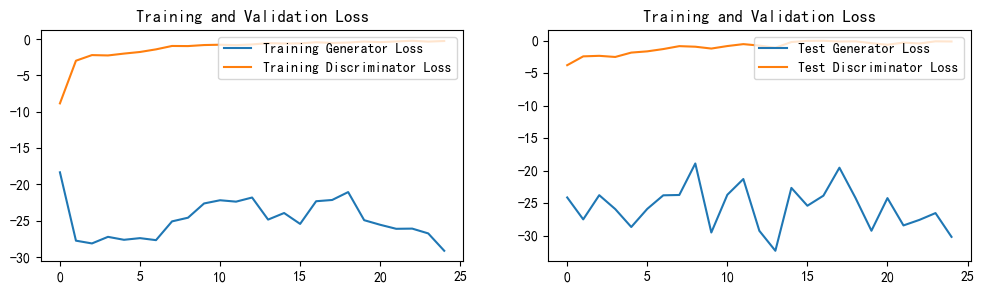

In [11]:
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_G, label='Training Generator Loss')
plt.plot(epochs_range, train_loss_D, label='Training Discriminator Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_loss_G, label='Test Generator Loss')
plt.plot(epochs_range, test_loss_D, label='Test Discriminator Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### 模型保存

In [14]:
# 指定保存路径
save_dir = '../models/4_GAN_Image_Generator'

# 确保目录存在，如果不存在则创建
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(generator.state_dict(), os.path.join(save_dir, 'MINIST_generator.pth'))